In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from wordcloud import WordCloud
import warnings

plt.rcParams['font.family']='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('float_format', '{:.2f}'.format)
warnings.filterwarnings(action='ignore')

In [2]:
raw_recipes = pd.read_csv('/opt/ml/foodcom/RAW_recipes.csv')
raw_interactions = pd.read_csv('/opt/ml/foodcom/RAW_interactions.csv')
pp_recipes = pd.read_csv('/opt/ml/foodcom/PP_recipes.csv')
pp_users = pd.read_csv('/opt/ml/foodcom/PP_users.csv')
interactions_train = pd.read_csv('/opt/ml/foodcom/interactions_train.csv')
interactions_validation = pd.read_csv('/opt/ml/foodcom/interactions_validation.csv')
interactions_test = pd.read_csv('/opt/ml/foodcom/interactions_test.csv')

# EDA

## raw_recipes

### Column 설명

name : 음식 이름

id : 음식 id

minutes : 걸리는 시간

contributor_id : 레시피 제공자 id

submitted : 등록된 날짜

tags : 레시피 관련 태그

nutrition : 영양소

n_steps : 과정 수

steps : 과정 상세

description : 설명

ingredients : 재료

n_ingredients : 재료 종류 수



In [4]:
# 결측값 확인
raw_recipes.isnull().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

In [3]:
# 레시피 이름 결측값 제거
name_null_id = raw_recipes[raw_recipes.name.isnull()].id.values
raw_recipes = raw_recipes[~raw_recipes.id.isin(name_null_id)]

### name


음식이 아닌 레시피가 존재

cleaner 와 washer 같은 세제류의 레시피도 포함되어 있음

In [4]:
print(raw_recipes[raw_recipes.name.str.contains('cleaner')].name.values)

['all purpose spray cleaner   dr  oz  show'
 'all in one magic non toxic bathroom cleaner'
 'awesome sparkling crystal clear windows cleaner'
 'draino    drain cleaner'
 'earth scrub  a green  soft scrub   all purpose cleaner'
 'easy microwave cleaner' 'eye glass cleaner' 'fantastic glass cleaner'
 'garbage disposal cleaner' 'green window cleaner that costs pennies'
 'handy hand cleaner' 'homemade window cleaner' 'magic cleaner'
 'multipurpose cleaner' 'natural floor cleaner' 'shower head cleaner'
 'smooth top stove cleaner' 'stainless steel pots   pans cleaner'
 'toilet cleaner' 'vacuum cleaner bar cookies' 'vacuum cleaner cookies'
 'washer cleaner']


### minutes

요리하는데 걸리는 시간은 0분 부터 2147483647분 까지 존재

75%까지 65분 이하라는 것을 확인 할 수 있음

In [5]:
raw_recipes.minutes.describe()

count       231636.00
mean          9398.59
std        4461972.67
min              0.00
25%             20.00
50%             40.00
75%             65.00
max     2147483647.00
Name: minutes, dtype: float64

/opt/conda/envs/test1/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


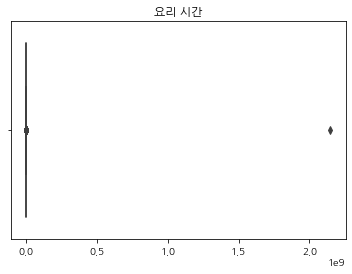

In [6]:
fig,ax = plt.subplots()

sns.boxplot(raw_recipes.minutes.values, ax=ax)
ax.set_title('요리 시간')

plt.show()

boxplot을 본 결과 이상치라고 판단됨

#### 0분 걸리는 레시피

In [7]:
zero_minutes_recipes = raw_recipes[raw_recipes.minutes == 0]
print('0분표기 레시피 수 =',zero_minutes_recipes.shape[0])
zero_minutes_recipes.head(5)

0분표기 레시피 수 = 1094


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
5,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4
2451,acorn magic delights,1712,0,1534,1999-10-01,"['15-minutes-or-less', 'time-to-make', 'course...","[148.4, 15.0, 28.0, 2.0, 3.0, 21.0, 4.0]",13,"['melt the butter or margarine over low heat',...",NaN,"['butter', 'brown sugar', 'pecans', 'all-purpo...",7
3079,albanian byrek,4880,0,1534,1999-11-24,"['15-minutes-or-less', 'time-to-make', 'course...","[354.4, 42.0, 25.0, 59.0, 37.0, 37.0, 2.0]",14,"['prepare the dough with flour , 1 and a half ...","the directions to this are vague, but maybe yo...","['flour', 'water', 'oil', 'vinegar', 'salt', '...",9
3193,alfredo sauce with pasta,3258,0,1534,1999-10-10,"['15-minutes-or-less', 'time-to-make', 'course...","[1902.9, 287.0, 5.0, 140.0, 104.0, 583.0, 3.0]",8,['cook noodles or fettuccine according to pack...,NaN,"['butter', 'heavy cream', 'parmesan cheese', '...",6
3259,alice s doughnuts,2284,0,1752,1999-10-18,"['15-minutes-or-less', 'time-to-make', 'course...","[107.3, 6.0, 20.0, 3.0, 3.0, 10.0, 4.0]",17,"['in a large bowl , beat the eggs until foamy'...",NaN,"['eggs', 'sugar', 'milk', 'shortening', 'vanil...",9


In [8]:
print('15분 이하 태그가 붙어있는 수',zero_minutes_recipes[zero_minutes_recipes.tags.str.contains('15-minutes')].shape[0])
zero_minutes_recipes[zero_minutes_recipes.tags.str.contains('15-minutes')].head(5)

15분 이하 태그가 붙어있는 수 1094


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
5,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,"['milk', 'vanilla ice cream', 'frozen apple ju...",4
2451,acorn magic delights,1712,0,1534,1999-10-01,"['15-minutes-or-less', 'time-to-make', 'course...","[148.4, 15.0, 28.0, 2.0, 3.0, 21.0, 4.0]",13,"['melt the butter or margarine over low heat',...",NaN,"['butter', 'brown sugar', 'pecans', 'all-purpo...",7
3079,albanian byrek,4880,0,1534,1999-11-24,"['15-minutes-or-less', 'time-to-make', 'course...","[354.4, 42.0, 25.0, 59.0, 37.0, 37.0, 2.0]",14,"['prepare the dough with flour , 1 and a half ...","the directions to this are vague, but maybe yo...","['flour', 'water', 'oil', 'vinegar', 'salt', '...",9
3193,alfredo sauce with pasta,3258,0,1534,1999-10-10,"['15-minutes-or-less', 'time-to-make', 'course...","[1902.9, 287.0, 5.0, 140.0, 104.0, 583.0, 3.0]",8,['cook noodles or fettuccine according to pack...,NaN,"['butter', 'heavy cream', 'parmesan cheese', '...",6
3259,alice s doughnuts,2284,0,1752,1999-10-18,"['15-minutes-or-less', 'time-to-make', 'course...","[107.3, 6.0, 20.0, 3.0, 3.0, 10.0, 4.0]",17,"['in a large bowl , beat the eggs until foamy'...",NaN,"['eggs', 'sugar', 'milk', 'shortening', 'vanil...",9


0분은 잘못 표시된 것이라고 보여짐

tags를 보면 15-minutes-or-less로 15분 이하 tag가 있는 것을 볼 수 있는데

0분 레시피에 모두 포함된 것을 확인 할 수 있음

#### 가장 오래걸리는 레시피

In [4]:
raw_recipes[raw_recipes.minutes == 2147483647]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
144074,no bake granola balls,261647,2147483647,464080,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course...","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oa...",healthy snacks that kids (and grown ups) will ...,"['rolled oats', 'unsweetened dried shredded co...",8


tag로는 60분 이하의 레시피로 보여짐

minutes 값은 잘못적혀진 것이라고 판단

100만분이 넘어가는 레시피도 위의 레시피를 제외하면 한개

In [6]:
raw_recipes[raw_recipes.minutes > 1000000]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
109624,how to preserve a husband,447963,1051200,576273,2011-02-01,"['time-to-make', 'course', 'preparation', 'for...","[407.4, 57.0, 50.0, 1.0, 7.0, 115.0, 5.0]",9,"['be careful in your selection', ""don't choose...","found this in a local wyoming cookbook ""a coll...","['cream', 'peach']",2
144074,no bake granola balls,261647,2147483647,464080,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course...","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oa...",healthy snacks that kids (and grown ups) will ...,"['rolled oats', 'unsweetened dried shredded co...",8


10만분 이상 걸리는 레시피는 liqueur (술) 종류가 많음

술을 담궈놓는 기간이라 minutes 값이 높게 측정됐다고 판단

In [7]:
raw_recipes[raw_recipes.minutes > 100000]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
5497,angelica liqueur,70551,201610,59064,2003-09-04,"['weeknight', 'time-to-make', 'course', 'cuisi...","[891.8, 0.0, 906.0, 0.0, 1.0, 0.0, 76.0]",7,"['crush the fennel , aniseed , coriander seeds...",finish off a large meal with a tiny glass of t...,"['fennel seed', 'anise seed', 'coriander seeds...",7
6545,apple cinnamon liqueur,236379,129615,327115,2007-06-21,"['time-to-make', 'course', 'preparation', 'low...","[4.2, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]",7,"['in a quart jar , add apple , cinnamon sticks...",this is amazing. a really nice amber color an...,"['granny smith apple', 'cinnamon sticks', 'vod...",6
26124,blueberry liqueur,236281,129615,327115,2007-06-21,"['time-to-make', 'course', 'preparation', 'low...","[4.2, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]",7,"['in a quart jar , blueberries , 1 cup sugar ,...",this is an absolutely beautiful shade of purpl...,"['blueberries', 'vodka', 'sugar', 'water', 'gl...",5
38116,celtic druid s honey mead meade metheglin,216215,259260,242729,2007-03-11,"['time-to-make', 'course', 'main-ingredient', ...","[531.0, 0.0, 561.0, 1.0, 1.0, 0.0, 47.0]",18,"['equipement:', 'very large pan - to hold 12 p...","mead, made from fermented honey, was the earli...","['gingerroot', 'lemons, juice and rind of', 'w...",7
41471,cherry liqueur,13345,144015,21752,2001-10-28,"['weeknight', 'time-to-make', 'course', 'main-...","[706.1, 0.0, 309.0, 0.0, 2.0, 0.0, 27.0]",19,"['mix vodka , brandy and sugar in a large glas...","my mother makes this all the time, she used to...","['red cherries', 'sugar', 'vodka', 'brandy']",4
53721,cinnamon extract,153634,172800,208121,2006-01-30,"['time-to-make', 'course', 'preparation', 'for...","[14.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5,"['put ingredients in container', 'combine', 'p...",a no brainer.. so why didn't i think of it? \r...,"['cinnamon sticks', 'vodka']",2
85835,framboise,240595,129630,219942,2007-07-15,"['time-to-make', 'course', 'main-ingredient', ...","[2217.7, 1.0, 632.0, 0.0, 4.0, 0.0, 57.0]",31,['pick over raspberries and discard any soft o...,this is a lovely raspberry liqueur. it's easy ...,"['fresh raspberries', 'vodka', 'sugar', 'disti...",4
102299,hard apple cider,2714,167040,1549,1999-08-16,"['weeknight', 'time-to-make', 'course', 'main-...","[306.2, 0.0, 291.0, 0.0, 1.0, 0.0, 25.0]",11,['crush and dissolve campden tablets in a cup ...,NaN,"['fresh apple juice', 'sugar', 'pectic enzyme ...",8
106563,homemade fruit liquers,291571,288000,553251,2008-03-12,"['time-to-make', 'course', 'main-ingredient', ...","[836.2, 0.0, 333.0, 0.0, 0.0, 0.0, 27.0]",12,"['rinse the fruit or berries , fruit must be c...",this should be a nice easy project for those w...,"['berries', 'vodka', 'granulated sugar']",3
106963,homemade vanilla,425681,259205,28177,2010-05-16,"['time-to-make', 'preparation', '5-ingredients...","[69.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9,['slice the vanilla beans length-wise and scra...,found this recipe on tammy's blog (http://www....,"['vanilla beans', 'vodka']",2


### tags

In [9]:
raw_recipes.tags

0         ['60-minutes-or-less', 'time-to-make', 'course...
1         ['30-minutes-or-less', 'time-to-make', 'course...
2         ['time-to-make', 'course', 'preparation', 'mai...
3         ['60-minutes-or-less', 'time-to-make', 'course...
4         ['weeknight', 'time-to-make', 'course', 'main-...
                                ...                        
231632    ['ham', '60-minutes-or-less', 'time-to-make', ...
231633    ['15-minutes-or-less', 'time-to-make', 'course...
231634    ['60-minutes-or-less', 'time-to-make', 'course...
231635    ['30-minutes-or-less', 'time-to-make', 'course...
231636    ['30-minutes-or-less', 'time-to-make', 'course...
Name: tags, Length: 231636, dtype: object

In [10]:
# 전체 tag 추출
tags = raw_recipes.tags.apply(lambda x: ast.literal_eval(x))
all_tags = set()
all_tags_list = []
for tag in tags.values:
    all_tags.update(tag)
    all_tags_list.extend(tag)
all_tags.discard('')

In [11]:
print('총 tag 개수 =',len(all_tags))
print('tag 별 사용된 횟수', Counter(all_tags_list))

총 tag 개수 = 551
tag 별 사용된 횟수 Counter({'preparation': 230545, 'time-to-make': 225325, 'course': 218147, 'main-ingredient': 170446, 'dietary': 165090, 'easy': 126061, 'occasion': 114145, 'cuisine': 91165, 'low-in-something': 85775, 'main-dish': 71786, 'equipment': 70436, '60-minutes-or-less': 69990, 'number-of-servings': 58949, 'meat': 56042, '30-minutes-or-less': 55077, 'vegetables': 53814, 'taste-mood': 52143, '4-hours-or-less': 49497, 'north-american': 48479, '3-steps-or-less': 44932, '15-minutes-or-less': 43933, 'low-sodium': 43348, 'desserts': 43203, 'low-carb': 42189, 'healthy': 40340, 'dinner-party': 37561, 'low-cholesterol': 36743, 'low-calorie': 36429, 'vegetarian': 35651, 'beginner-cook': 35561, '5-ingredients-or-less': 35466, 'holiday-event': 34920, 'inexpensive': 32618, 'low-protein': 32521, 'low-saturated-fat': 31378, 'fruit': 31324, 'oven': 31180, 'american': 31179, 'eggs-dairy': 30142, 'pasta-rice-and-grains': 27084, 'kid-friendly': 27074, 'side-dishes': 26902, 'healthy-2':

In [12]:
# wordcloud
ct = Counter(all_tags_list)
wc = WordCloud(background_color='white', max_font_size=50, width=1000, height=600)
cloud = wc.generate_from_frequencies(dict(ct))

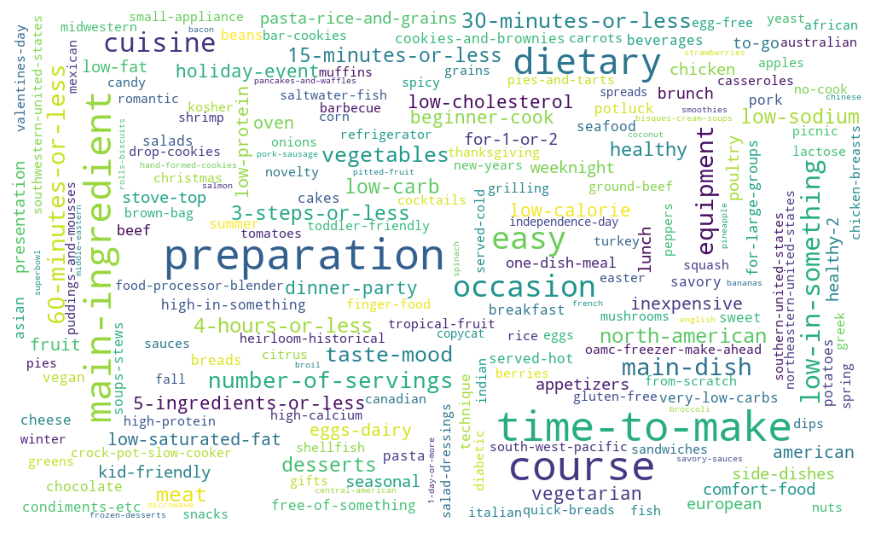

In [13]:
fig, ax = plt.subplots(figsize=(10,10), dpi=110)
ax.axis('off')
ax.imshow(cloud)
plt.show()

레시피의 특성을 나타내주는 단어들의 집합으로 볼 수 있음

잘 활용한다면 추천이나 분류에 사용 가능할 것으로 생각함

### steps, n_steps

steps는 요리 과정 정보

요리 과정에도 재료, 도구 등등 다양한 정보가 있기 때문에 nlp를 이용하면 뭔가 할 수 있을지도..?

In [14]:
raw_recipes.steps

0         ['make a choice and proceed with recipe', 'dep...
1         ['preheat oven to 425 degrees f', 'press dough...
2         ['brown ground beef in large pot', 'add choppe...
3         ['place potatoes in a large pot of lightly sal...
4         ['mix all ingredients& boil for 2 1 / 2 hours ...
                                ...                        
231632    ['heat oil in a 4-quart dutch oven', 'add cele...
231633          ['mix all ingredients together thoroughly']
231634    ['in a bowl , combine the mashed yolks and may...
231635    ['place melted butter in a large mixing bowl a...
231636    ['whip sugar and shortening in a large bowl , ...
Name: steps, Length: 231636, dtype: object

n_steps는 요리 과정의 개수

In [15]:
raw_recipes.n_steps.describe()

count   231636.00
mean         9.77
std          6.00
min          0.00
25%          6.00
50%          9.00
75%         12.00
max        145.00
Name: n_steps, dtype: float64

n_steps 가 0인 것은 누락된 것으로 보여짐

In [16]:
raw_recipes[raw_recipes.n_steps == 0]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
3381,all season bread,176767,90,331268,2006-07-10,"['time-to-make', 'course', 'main-ingredient', ...","[198.8, 11.0, 70.0, 18.0, 5.0, 5.0, 10.0]",0,[],just change the fruit/vegetable in this recipe...,"['flour', 'baking soda', 'salt', 'baking powde...",12


요리 과정이 가장 많은 레시피

요리 과정의 적고 많음이 요리의 난이도와 연관 지을 수 있을지는 생각해봐야 할듯

In [17]:
raw_recipes[raw_recipes.n_steps == 145]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
78633,easy yeast bread with variations,158120,210,182358,2006-02-28,"['time-to-make', 'course', 'preparation', 'hea...","[1784.5, 62.0, 104.0, 151.0, 103.0, 42.0, 99.0]",145,"['white bread:', 'lightly spooning flour into ...",found online in response to a request and now ...,"['all-purpose flour', 'dry yeast', 'sugar', 's...",8


### ingredients, n_ingredients

In [18]:
raw_recipes.ingredients

0         ['winter squash', 'mexican seasoning', 'mixed ...
1         ['prepared pizza crust', 'sausage patty', 'egg...
2         ['ground beef', 'yellow onions', 'diced tomato...
3         ['spreadable cheese with garlic and herbs', 'n...
4         ['tomato juice', 'apple cider vinegar', 'sugar...
                                ...                        
231632    ['celery', 'onion', 'green sweet pepper', 'gar...
231633    ['paprika', 'salt', 'garlic powder', 'onion po...
231634    ['hard-cooked eggs', 'mayonnaise', 'dijon must...
231635    ['butter', 'eagle brand condensed milk', 'ligh...
231636    ['granulated sugar', 'shortening', 'eggs', 'fl...
Name: ingredients, Length: 231636, dtype: object

In [19]:
# 전체 재료 추출
ingredients = raw_recipes.ingredients.apply(lambda x: ast.literal_eval(x))
all_ingredients = set()
all_ingredients_list = []
for ingredient in ingredients.values:
    all_ingredients.update(ingredient)
    all_ingredients_list.extend(ingredient)
all_ingredients.discard('')

In [20]:
print('총 ingredient 개수 =',len(all_ingredients))
print('ingredient 별 사용된 횟수', Counter(all_ingredients_list))

총 ingredient 개수 = 14942
ingredient 별 사용된 횟수 Counter({'salt': 85746, 'butter': 54975, 'sugar': 44535, 'onion': 39065, 'water': 34914, 'eggs': 33761, 'olive oil': 32821, 'flour': 26266, 'milk': 25786, 'garlic cloves': 25748, 'pepper': 22319, 'brown sugar': 18655, 'garlic': 18087, 'all-purpose flour': 17659, 'baking powder': 17504, 'egg': 17304, 'salt and pepper': 15415, 'parmesan cheese': 14807, 'lemon juice': 14233, 'baking soda': 14099, 'vegetable oil': 13912, 'vanilla': 13315, 'black pepper': 13097, 'cinnamon': 12560, 'tomatoes': 11950, 'sour cream': 11779, 'garlic powder': 10887, 'vanilla extract': 10271, 'oil': 9925, 'honey': 9897, 'onions': 9872, 'cream cheese': 9827, 'garlic clove': 9778, 'celery': 9541, 'cheddar cheese': 8969, 'unsalted butter': 8935, 'soy sauce': 8856, 'mayonnaise': 8736, 'paprika': 7982, 'chicken broth': 7963, 'worcestershire sauce': 7832, 'extra virgin olive oil': 7704, 'fresh parsley': 7656, 'cornstarch': 7486, 'fresh ground black pepper': 7160, 'carrots': 70

전체 레시피에 사용된 총 재료는 약 15000개

조미료와 같은 재료들도 많이 포함돼 있기 때문에 메인 재료를 찾아낼 수 있는 방법을 고안해봐도 될듯함

레시피 수에 비해 적게 사용되는 재료들이 많음

In [21]:
raw_recipes.n_ingredients.describe()

count   231636.00
mean         9.05
std          3.73
min          1.00
25%          6.00
50%          9.00
75%         11.00
max         43.00
Name: n_ingredients, dtype: float64

재료가 1개만 들어가는 레시피가 있는 반면 43개로 많은 재료가 들어가는 레시피도 확인 할 수 있음

### nutrition

In [22]:
raw_recipes.nutrition.values[:10]

array(['[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]',
       '[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]',
       '[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]',
       '[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]',
       '[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]',
       '[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]',
       '[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]',
       '[1109.5, 83.0, 378.0, 275.0, 96.0, 86.0, 36.0]',
       '[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 220.0]',
       '[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]'], dtype=object)

영양소는 Mulit-hot vector 로 수치만 주어졌지만 kaggle 에서 정보를 찾을 수 있음

순서대로

calories, total fat (PDV), sugar (PDV), sodium (PDV), protein (PDV), saturated fat (PDV), carbohydrates (PDV)

In [23]:
# 영양소 정보를 추가하는 코드
raw_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']] = raw_recipes.nutrition.str.split(",",expand=True)
raw_recipes['calories'] =  raw_recipes['calories'].apply(lambda x: x.replace('[',''))
raw_recipes['carbohydrates (PDV)'] =  raw_recipes['carbohydrates (PDV)'].apply(lambda x: x.replace(']',''))
raw_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']] = raw_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']].astype('float')

In [24]:
raw_recipes[['calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)','saturated fat (PDV)','carbohydrates (PDV)']].describe()

,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,231636.00,231636.00,231636.00,231636.00,231636.00,231636.00,231636.00
mean,473.94,36.08,84.30,30.15,34.68,45.59,15.56
std,1189.71,77.80,800.08,131.96,58.47,98.24,81.82
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,174.38,8.00,9.00,5.00,7.00,7.00,4.00
50%,313.40,20.00,25.00,14.00,18.00,23.00,9.00
75%,519.70,41.00,68.00,33.00,51.00,52.00,16.00
max,434360.20,17183.00,362729.00,29338.00,6552.00,10395.00,36098.00


칼로리가 0인것도 있고 434360인 것이 있음

In [25]:
raw_recipes[raw_recipes.calories == 0].head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
4707,amazing stain remover,99542,11,158600,2004-09-09,"['15-minutes-or-less', 'time-to-make', 'prepar...","[0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0]",6,"['fill sink or bucket with cold water', 'slowl...",my aunt gave this to me and told me it worked ...,"['cold water', 'laundry detergent', 'bleach']",3,0.00,0.00,0.00,3.00,0.00,0.00,0.00
10758,authentic german black bread schwarzbrot,446730,1170,1796418,2011-01-18,"['lactose', 'course', 'main-ingredient', 'cuis...","[0.0, 0.0, 0.0, 145.0, 0.0, 0.0, 0.0]",20,"['combine the water , sourdough starter , and ...","this is a traditional, 100% rye bread that is ...","['water', 'sourdough starter', 'rye berries', ...",4,0.00,0.00,0.00,145.00,0.00,0.00,0.00
19827,bee or wasp sting soother,253566,5,333581,2007-09-18,"['15-minutes-or-less', 'time-to-make', 'prepar...","[0.0, 0.0, 0.0, 104.0, 0.0, 0.0, 0.0]",4,"['using a credit card , scrape over where the ...",when i was little and lived in the country i u...,"['baking soda', 'water']",2,0.00,0.00,0.00,104.00,0.00,0.00,0.00
28942,brining solution for poultry and meat,325203,120,18745,2008-09-15,"['time-to-make', 'course', 'main-ingredient', ...","[0.0, 0.0, 0.0, 295.0, 0.0, 0.0, 0.0]",10,['mix salt with water and stir to dissolve sal...,i found this technique in and old butchers rec...,"['cold water', 'kosher salt']",2,0.00,0.00,0.00,295.00,0.00,0.00,0.00
37985,cedar planked anything,319274,5,437727,2008-08-13,"['15-minutes-or-less', 'time-to-make', 'prepar...","[0.0, 0.0, 0.0, 293.0, 0.0, 0.0, 0.0]",4,['soak wood planks in desired liquids with sal...,this is more of a tip than a recipe....i love ...,"['cedar plank', 'water', 'salt', 'plastic wrap...",5,0.00,0.00,0.00,293.00,0.00,0.00,0.00


0칼로리를 확인해보니 amazing stain remover, washer cleaner, homemade window cleaner 와 같이 세제나 청소용 리무머 같은게 포함돼있음

In [27]:
raw_recipes[raw_recipes.calories == 434360.20]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
209453,tennessee moonshine,193435,20,374913,2006-11-01,"['30-minutes-or-less', 'time-to-make', 'course...","[434360.2, 1293.0, 362729.0, 1324.0, 3961.0, 5...",3,['to boiled cornmeal add yeast and lots of sug...,common moonshine recipe in tennessee,"['cornmeal', 'natural bran', 'sugar', 'yeast',...",5,434360.20,1293.00,362729.00,1324.00,3961.00,590.00,36098.00


가장 높은 칼로리를 가지고 있는 레피시는 대용량으로 만들어져서 높게 표시는되는 것으로 생각됨

영양소의 정보는 g당 기준이 아니기 때문에 정보로 사용하기엔 애매할 것으로 판단

## raw_interactions

In [28]:
raw_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [29]:
print('유저id 수', raw_interactions.user_id.nunique())
print('유저가 만든 레시피 수', raw_interactions.recipe_id.nunique())
print('총 레시피 중 유저가 만든 레시피 비율', raw_interactions.recipe_id.nunique()/raw_recipes.id.nunique() * 100)

유저id 수 226570
유저가 만든 레시피 수 231637
총 레시피 중 유저가 만든 레시피 비율 100.00043171182374


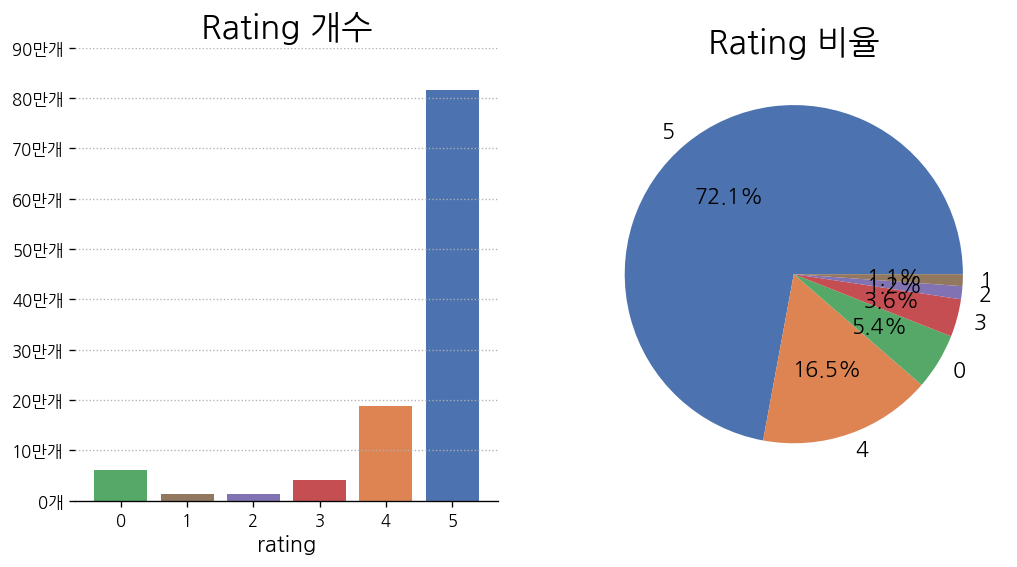

In [30]:
fig, ax = plt.subplots(1,2,figsize=(10,5), dpi=120)

ax[0].spines['left'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
color = sns.color_palette('deep', 6)
ax[0].bar(raw_interactions.rating.value_counts().index, raw_interactions.rating.value_counts().values, color=color)

ax[0].set_title('Rating 개수', fontsize=20)
ax[0].set_ylabel("")
ax[0].set_xlabel("rating", fontsize=13)

yticks = ax[0].get_yticks()
ax[0].set_yticks(yticks)
ax[0].set_yticklabels([f'{0}개' if i==0.0 else f'{i//10000:.0f}만개' for i in yticks])

ax[0].grid(axis='y', linestyle=':', which='major')

# pie
ax[1].pie(raw_interactions.rating.value_counts(), labels=raw_interactions.rating.value_counts().index, autopct='%1.1f%%', colors=color, textprops={'fontsize': 13})
ax[1].set_title('Rating 비율', fontsize=20)

plt.show()

rating 정보는 imbalance 한 분포를 가지고 있음

In [35]:
print(raw_interactions[raw_interactions.rating == 0].review[:5])

6     Just an observation, so I will not rate.  I fo...
12    Made my own buttermilk w/ vinegar and milk.  U...
23    This is a very good recipe.  We also want to c...
39                         i made it and it was amazing
56    I used half cream and half 1% milk, added anot...
Name: review, dtype: object


0점 리뷰 중에는 긍정적인 리뷰도 포함되어 있음

점수가 누락됐거나 잘못된 리뷰일수도 있음

In [36]:
raw_interactions.user_id.value_counts().describe()

count   226570.00
mean         5.00
std         49.66
min          1.00
25%          1.00
50%          1.00
75%          2.00
max       7671.00
Name: user_id, dtype: float64

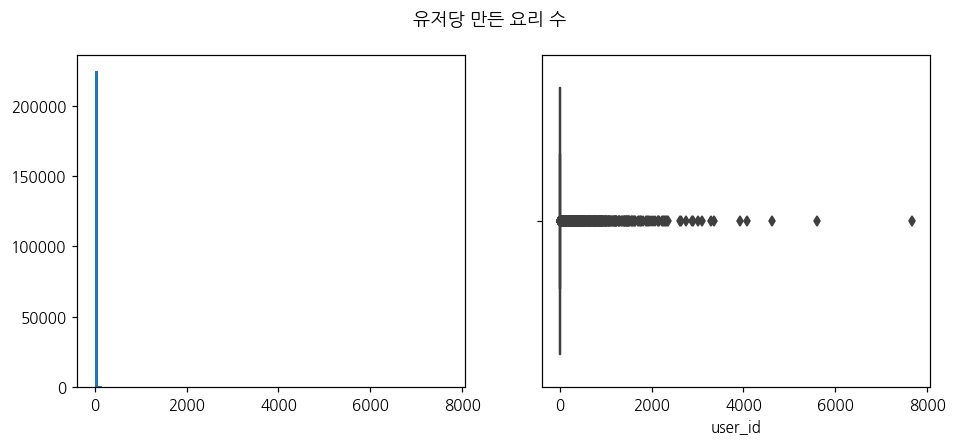

count   226570.00
mean         5.00
std         49.66
min          1.00
25%          1.00
50%          1.00
75%          2.00
max       7671.00
Name: user_id, dtype: float64


In [47]:
fig, ax = plt.subplots(1,2,figsize=(10,4), dpi=110)

ax[0].hist(raw_interactions.user_id.value_counts(), bins=100)
sns.boxplot(raw_interactions.user_id.value_counts(), ax=ax[1])

plt.suptitle('유저당 만든 요리 수')
plt.show()

print(raw_interactions.user_id.value_counts().describe())

레시피를 1개만 사용해본 유저가 50%이상을 차지하는 것을 볼 수 있음

## pp_recipes

토큰화 되어있는 데이터셋으로 대부분의 정보가 raw데이터에 존재

In [49]:
pp_recipes.head()

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


raw 데이터에는 없는 정보는 techniques, calorie_level

In [50]:
pp_recipes.techniques

0         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
1         [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
2         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
3         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
                                ...                        
178260    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
178261    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
178262    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
178263    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
178264    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: techniques, Length: 178265, dtype: object

Multi-hot vector로 이루어져있고 이 정보는 kaggle에서 찾을 수 있음

In [5]:
TECHNIQUES_LIST = [
    'bake',
    'barbecue',
    'blanch',
    'blend',
    'boil',
    'braise',
    'brine',
    'broil',
    'caramelize',
    'combine',
    'crock pot',
    'crush',
    'deglaze',
    'devein',
    'dice',
    'distill',
    'drain',
    'emulsify',
    'ferment',
    'freez',
    'fry',
    'grate',
    'griddle',
    'grill',
    'knead',
    'leaven',
    'marinate',
    'mash',
    'melt',
    'microwave',
    'parboil',
    'pickle',
    'poach',
    'pour',
    'pressure cook',
    'puree',
    'refrigerat',
    'roast',
    'saute',
    'scald',
    'scramble',
    'shred',
    'simmer',
    'skillet',
    'slow cook',
    'smoke',
    'smooth',
    'soak',
    'sous-vide',
    'steam',
    'stew',
    'strain',
    'tenderize',
    'thicken',
    'toast',
    'toss',
    'whip',
    'whisk',
]

In [51]:
pp_recipes.calorie_level.unique()

array([0, 1, 2])

In [52]:
pp_recipes.calorie_level.value_counts()

0    69699
1    63255
2    45311
Name: calorie_level, dtype: int64

calorie_level은 raw데이터 확인했을때 calorie가 기준이 없기때문에 사용하기 애매하다고 판단

## pp_users

In [53]:
pp_users.head()

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


user마다 techniques 정보가 주어져있어서 어떤식으로 수치화 됐는지 확인

확인 결과 유저가 사용한 레시피에 있는 techniques 의 단순 합산으로 수치 결정

In [28]:
print(pp_users[pp_users.u == 23000].techniques.values)
print('=================================================================================================')

print('1',pp_recipes[pp_recipes.i == 104526].techniques.values)
print('2',pp_recipes[pp_recipes.i == 52975].techniques.values)
print('3',pp_recipes[pp_recipes.i == 82007].techniques.values)

['[2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]']
1 ['[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]']
2 ['[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]']
3 ['[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]']


## train, val, test

데이터셋이 나뉜 기준은 food.com 논문에서 확인 할 수 있었음

https://aclanthology.org/D19-1613/

In [30]:
interactions_train.head(3)

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181


In [31]:
interactions_validation.head(3)

,user_id,recipe_id,date,rating,u,i
0,76535,33627,2005-02-15,4.0,5,177317
1,160497,75307,2005-10-24,4.0,23,170785
2,930021,100961,2008-11-30,4.0,31,165555


In [32]:
interactions_test.head(3)

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896


In [33]:
total = pd.concat([interactions_train,interactions_validation,interactions_test], axis=0)
total

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723
...,...,...,...,...,...,...
12450,101053,179011,2009-01-03,5.0,25054,130258
12451,252205,81398,2005-12-26,2.0,25055,152255
12452,624305,142984,2011-01-15,1.0,25057,139864
12453,173575,104842,2004-12-18,3.0,25059,140646


In [34]:
print('데이터셋에 사용된 유저수 비율',total.user_id.nunique()/raw_interactions.user_id.nunique() * 100)
print('데이터셋에 사용된 레시피 수 비율',total.recipe_id.nunique()/raw_interactions.recipe_id.nunique() * 100)

데이터셋에 사용된 유저수 비율 11.067661208456547
데이터셋에 사용된 레시피 수 비율 76.95877601592146


In [35]:
print('총 유저수',total.user_id.nunique())
print('총 레시피수',total.recipe_id.nunique())

총 유저수 25076
총 레시피수 178265


<AxesSubplot:>

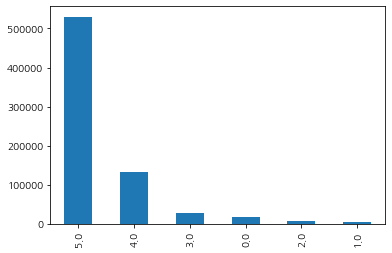

In [36]:
total.rating.value_counts().plot.bar()

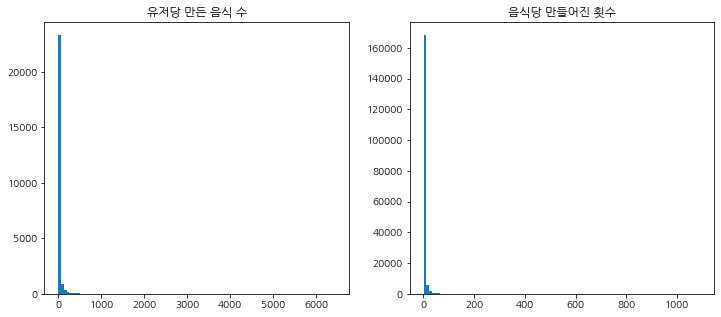

In [37]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(total.user_id.value_counts(), bins=100)
ax[0].set_title('유저당 만든 음식 수')

ax[1].hist(total.recipe_id.value_counts(), bins=100)
ax[1].set_title('음식당 만들어진 횟수')

plt.show()

결론 : raw 데이터와 큰 차이점을 발견하지 못함

raw 데이터를 가공해서 사용하기로 결정

# 생각해볼 점

### 요리시간이 긴 음식을 추천하는게 맞을까?

In [4]:
raw_recipes = raw_recipes.dropna(axis=0)

In [5]:
raw_recipes.minutes.describe()

count       226657.00
mean          9602.47
std        4510714.76
min              0.00
25%             20.00
50%             40.00
75%             65.00
max     2147483647.00
Name: minutes, dtype: float64

요리하는데 걸리는 시간이 비정상적으로 오래걸리는 레시피가 존재함

In [6]:
raw_recipes[raw_recipes.minutes > 100000]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
5497,angelica liqueur,70551,201610,59064,2003-09-04,"['weeknight', 'time-to-make', 'course', 'cuisi...","[891.8, 0.0, 906.0, 0.0, 1.0, 0.0, 76.0]",7,"['crush the fennel , aniseed , coriander seeds...",finish off a large meal with a tiny glass of t...,"['fennel seed', 'anise seed', 'coriander seeds...",7
6545,apple cinnamon liqueur,236379,129615,327115,2007-06-21,"['time-to-make', 'course', 'preparation', 'low...","[4.2, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]",7,"['in a quart jar , add apple , cinnamon sticks...",this is amazing. a really nice amber color an...,"['granny smith apple', 'cinnamon sticks', 'vod...",6
26124,blueberry liqueur,236281,129615,327115,2007-06-21,"['time-to-make', 'course', 'preparation', 'low...","[4.2, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0]",7,"['in a quart jar , blueberries , 1 cup sugar ,...",this is an absolutely beautiful shade of purpl...,"['blueberries', 'vodka', 'sugar', 'water', 'gl...",5
38116,celtic druid s honey mead meade metheglin,216215,259260,242729,2007-03-11,"['time-to-make', 'course', 'main-ingredient', ...","[531.0, 0.0, 561.0, 1.0, 1.0, 0.0, 47.0]",18,"['equipement:', 'very large pan - to hold 12 p...","mead, made from fermented honey, was the earli...","['gingerroot', 'lemons, juice and rind of', 'w...",7
41471,cherry liqueur,13345,144015,21752,2001-10-28,"['weeknight', 'time-to-make', 'course', 'main-...","[706.1, 0.0, 309.0, 0.0, 2.0, 0.0, 27.0]",19,"['mix vodka , brandy and sugar in a large glas...","my mother makes this all the time, she used to...","['red cherries', 'sugar', 'vodka', 'brandy']",4
53721,cinnamon extract,153634,172800,208121,2006-01-30,"['time-to-make', 'course', 'preparation', 'for...","[14.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",5,"['put ingredients in container', 'combine', 'p...",a no brainer.. so why didn't i think of it? \r...,"['cinnamon sticks', 'vodka']",2
85835,framboise,240595,129630,219942,2007-07-15,"['time-to-make', 'course', 'main-ingredient', ...","[2217.7, 1.0, 632.0, 0.0, 4.0, 0.0, 57.0]",31,['pick over raspberries and discard any soft o...,this is a lovely raspberry liqueur. it's easy ...,"['fresh raspberries', 'vodka', 'sugar', 'disti...",4
106563,homemade fruit liquers,291571,288000,553251,2008-03-12,"['time-to-make', 'course', 'main-ingredient', ...","[836.2, 0.0, 333.0, 0.0, 0.0, 0.0, 27.0]",12,"['rinse the fruit or berries , fruit must be c...",this should be a nice easy project for those w...,"['berries', 'vodka', 'granulated sugar']",3
106963,homemade vanilla,425681,259205,28177,2010-05-16,"['time-to-make', 'preparation', '5-ingredients...","[69.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9,['slice the vanilla beans length-wise and scra...,found this recipe on tammy's blog (http://www....,"['vanilla beans', 'vodka']",2
106964,homemade vanilla extract,463624,129600,1722785,2011-09-05,"['time-to-make', 'preparation', 'occasion', 'f...","[75.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",12,"['carefully open the bottle of brandy', 'pour ...",after getting a very poor bottle of vanilla ex...,"['brandy', 'vanilla beans']",2


오래걸리는 음식들은 술과 같이 어느정도의 숙성이 필요한 것들이 있음   
이런거는 추천을 할 때, 해줘되는지 고민을 해봐야 할 거 같음

### 요리 도구 관련

steps 를 확인하면 도구 사용을 언급하는 부분이 확인됨

In [4]:
raw_recipes.steps[1]

"['preheat oven to 425 degrees f', 'press dough into the bottom and sides of a 12 inch pizza pan', 'bake for 5 minutes until set but not browned', 'cut sausage into small pieces', 'whisk eggs and milk in a bowl until frothy', 'spoon sausage over baked crust and sprinkle with cheese', 'pour egg mixture slowly over sausage and cheese', 's& p to taste', 'bake 15-20 minutes or until eggs are set and crust is brown']"

이 레시피를 확인하면 오븐을 사용한다는 것을 알 수 있음   
근데 모든 가정집에 오븐이 있는거도 아니기 때문에 추천과정에서 이부분은 고려를 해봐야겠다고 생각함   
조리 과정에 oven 이라는 단어가 들어가는 것이 약 7만개가 넘음   
오븐 외에도 mivcrowave, air fryer등 다양한 조리도구가 있음

In [5]:
raw_recipes[raw_recipes.steps.str.contains('oven')].head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
7,backyard style barbecued ribs,67888,120,10404,2003-07-30,"['weeknight', 'time-to-make', 'course', 'main-...","[1109.5, 83.0, 378.0, 275.0, 96.0, 86.0, 36.0]",10,['in a medium saucepan combine all the ingredi...,this recipe is posted by request and was origi...,"['pork spareribs', 'soy sauce', 'fresh garlic'...",22
9,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9
12,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13


이런 정보들은 tags에도 포함되어있음

In [7]:
raw_recipes[raw_recipes.tags.str.contains('oven')].head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
7,backyard style barbecued ribs,67888,120,10404,2003-07-30,"['weeknight', 'time-to-make', 'course', 'main-...","[1109.5, 83.0, 378.0, 275.0, 96.0, 86.0, 36.0]",10,['in a medium saucepan combine all the ingredi...,this recipe is posted by request and was origi...,"['pork spareribs', 'soy sauce', 'fresh garlic'...",22
9,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9
12,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13


In [8]:
# oven이 사용되는 레시피
use_oven_recipes = raw_recipes[(raw_recipes.steps.str.contains('oven') | raw_recipes.tags.str.contains('oven'))]

In [10]:
print(use_oven_recipes.shape[0] / raw_recipes.shape[0])

0.3648094424010085


전체 레시피 중 오븐이 사용되는 레시피가 36.4%를 차지하고 있기 때문에 필터링 조건으로 사용해도 될 것이라고 판단

### 사용자의 review 감성분석

In [16]:
from transformers import pipeline
import re
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

In [5]:
sentiment_analysis = pipeline("sentiment-analysis", max_length=512, truncation=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [6]:
def func(x):
    result = sentiment_analysis(x)
    if result[0]['label'] == 'NEGATIVE':
        return 0
    elif result[0]['label'] == 'POSITIVE':
        return 1

random sample data (user interaction 10만개)

In [19]:
sample_interactions = raw_interactions.sample(100000, random_state=42).reset_index(drop=True)

review 전처리

In [22]:
sample_interactions['review'] = sample_interactions['review'].str.lower().apply(lambda x: re.sub("[()&/;.*,!?\\\-]", '', str(x)))

In [ ]:

# model 진행
sample_interactions['sentiment_result'] = sample_interactions['review'].progress_apply(lambda x: func(x))


In [ ]:
sample_interactions['rate'] = sample_interactions['rating'].apply(lambda x: 1 if x>=3 else 0)

In [ ]:
cf = confusion_matrix(sample_interactions.rate, sample_interactions.sentiment_result)
print(cf)

In [ ]:
sample_interactions.groupby[['rate','sentiment_result']].agg({'sentiment_result':'count'})

실제 점수로 긍정인데 review 분석 결과는 부정으로 인식한 결과가 많음